# Notes
- maybe cut it down to one control input (only forward)

In [1]:
!python -m pip install einops casadi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Function
from torch.autograd.functional import hessian, jacobian
from torch.utils.data import Dataset, DataLoader, random_split

import einops
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import casadi as ca
import numpy as np
import time
from tqdm import tqdm


%config InlineBackend.figure_formats = ['svg']

torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch_device)

cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
horizon = 8  # 8 steps
dt = 0.25    # 4 Hz

rec_dt = 0.025  # 40 Hz data collection

every_n = int(dt/rec_dt)
print(every_n)

10


In [5]:
class FieldDataset(Dataset):
    def __init__(self, file_dir='data/robot_field_data.pt'):
        grids, commands = torch.load(file_dir)
        
        self.grids = grids[::every_n].to(torch.float32)
        self.commands = commands[::every_n][:,[0,1,5]].to(torch.float32)  # get u_x, u_y, u_w

    def __len__(self):
        return len(self.grids) - horizon

    def __getitem__(self, idx):
        grid = self.grids[idx]
        commands = self.commands[idx:idx+horizon]
        return grid, commands

In [6]:
dataset = FieldDataset('/content/drive/MyDrive/CS 282A Final Project/data/pre_processed_data/robot_field_data.pt')
print(len(dataset))

2364


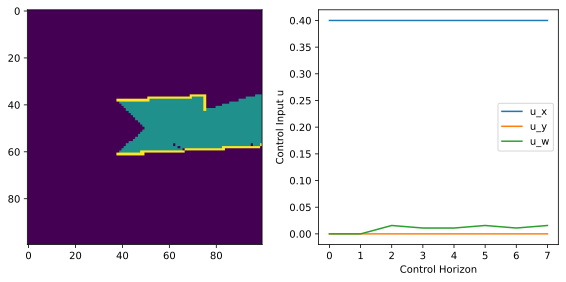

In [7]:
grid, command = dataset.__getitem__(410)
# idx 410 at 8 Hz

# Create a gridspec with two columns and one row
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], height_ratios=[1])

# Assign axes to the gridspec
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.imshow(grid.cpu())
ax2.plot(command.cpu(), label=['u_x', 'u_y', 'u_w'])
ax2.set_xlabel('Control Horizon')
ax2.set_ylabel('Control Input u')
ax2.legend()

# Set the figure size and layout
fig = plt.gcf()
fig.set_size_inches(8, 4)
fig.tight_layout()

# Show the figure
plt.show()

In [8]:
train_ratio = 0.8

train_size = int((train_ratio) * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f'Length of training dataset: {len(train_dataset)}')
print(f'Length of validation dataset: {len(val_dataset)}')

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Length of training dataset: 1891
Length of validation dataset: 473


In [9]:
def patchify(images, patch_size=5):
    """Splitting images into patches.
    Args:
        images: Input tensor with size (batch, channels, height, width)
    Returns:
        A batch of image patches with size (
          batch, (height / patch_size) * (width / patch_size), 
        channels * patch_size * patch_size)
    """
    return einops.rearrange(
        images,
        'b (h p1) (w p2) -> b (h w) (p1 p2)',
        p1=patch_size,
        p2=patch_size
    )

def unpatchify(patches, patch_size=5):
    """Combining patches into images.
    Args:
        patches: Input tensor with size (
        batch, (height / patch_size) * (width / patch_size), 
        channels * patch_size * patch_size)
    Returns:
        A batch of images with size (batch, channels, height, width)
    """
    return einops.rearrange(
        patches,
        'b (h w) (p1 p2) -> b (h p1) (w p2)',
        p1=patch_size,
        p2=patch_size,
        h=int(patches.shape[1] ** 0.5),
        w=int(patches.shape[1] ** 0.5),
    )

In [10]:
class Transformer(nn.Module):
    """Transformer Encoder 
    Args:
        embedding_dim: dimension of embedding
        n_heads: number of attention heads
        n_layers: number of attention layers
        feedforward_dim: hidden dimension of MLP layer
    Returns:
        Transformer embedding of input
    """
    # TODO embedding_dim? -> size of Q,p ???
    def __init__(self, embedding_dim=256, n_heads=1, n_layers=3, feedforward_dim=64):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.feedforward_dim = feedforward_dim
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embedding_dim,
                nhead=self.n_heads,
                dim_feedforward=self.feedforward_dim,
                activation=F.gelu,
                batch_first=True,
                dropout=0.1,
            ),
            num_layers=n_layers,
        )

    def forward(self, x):
        return self.transformer(x)

In [11]:
x0 = torch.Tensor([0, 0, 0]).to(torch_device)
x0.requires_grad=True
u0 = torch.Tensor([0, 0, 0]).to(torch_device)
u0.requires_grad=True
u_des = torch.Tensor([0.4, 0, 0]).to(torch_device)
u_des.requires_grad=True

In [12]:
opt_N=horizon
opt_dt=dt

opti = ca.Opti()

opt_x=opti.variable(3, opt_N+1)
opt_u=opti.variable(3, opt_N)

opt_x0 = opti.parameter(3)
opt_u0 = opti.parameter(3)

opt_u_des = opti.parameter(3)

opt_P = opti.parameter(6, 6)
opt_q = opti.parameter(6)

# stage cost
cost = 0
for i in range(opt_N):
  cost += 0.1*(ca.vertcat(opt_x[:, i], opt_u[:, i]).T @ opt_P.T @ opt_P @ ca.vertcat(opt_x[:, i], opt_u[:, i])
                   + opt_q.T @ ca.vertcat(opt_x[:, i], opt_u[:, i]))
  cost += 10*(opt_u_des - opt_u[:, i]).T @ (opt_u_des - opt_u[:, i])
  
opti.minimize(cost)

# system dynamics
for i in range(opt_N):
  opti.subject_to(opt_x[0, i+1] == opt_x[0, i] + opt_dt * (ca.cos(opt_x[2, i]) * opt_u[0, i] - ca.sin(opt_x[2, i]) * opt_u[1, i] + opt_u[2, i]) )
  opti.subject_to(opt_x[1, i+1] == opt_x[1, i] + opt_dt * (ca.sin(opt_x[2, i]) * opt_u[0, i] + ca.cos(opt_x[2, i]) * opt_u[1, i] + opt_u[2, i]))
  opti.subject_to(opt_x[2, i+1] == opt_x[2, i] + opt_dt * (opt_u[2, i]))
  
  # constraints on control rate
  # for i in range(N):
  #   opti.subject_to( u[:,i+1] - u[:,i] <= np.array([0.1, 0.1, 0.1]) )
  #   opti.subject_to( u[:,i+1] - u[:,i] >= -np.array([0.1, 0.1, 0.1]) )
  # opti.subject_to( u[:,0] - u0 <= np.array([0.1, 0.1, 0.1]) )
  # opti.subject_to( u[:,0] - u0 >= -np.array([0.1, 0.1, 0.1]) )
  
  # initial condition
  opti.subject_to(opt_x[:, 0] == opt_x0)
  
opti.solver('ipopt', {'ipopt.print_level':0, 'print_time':0})

In [13]:
class CFTOC(Function):
  @staticmethod
  def forward(ctx, embedding, x0, u0, u_des):     
    # split and reshape to get P and q for CFTOC cost function
    P, q = torch.split(embedding, [36, 6], dim=1)
    P = P.view(P.shape[0], 6, 6)
    batch_dim = P.shape[0]
    
    u_opt = []
    x_opt = []
    
    # loop through batch
    for i in range(batch_dim):
      # print(f'Optimizing CFTOC problem on batch entry {i}')
      opti.set_value(opt_x0, x0.detach().cpu().numpy())
      opti.set_value(opt_u0, u0.detach().cpu().numpy())
    
      opti.set_value(opt_u_des, u_des.detach().cpu().numpy())

      opti.set_value(opt_P, P[i].detach().cpu().numpy())
      opti.set_value(opt_q, q[i].detach().cpu().numpy())

      sol = opti.solve()

      u_opt.append(sol.value(opt_u))        
      x_opt.append(sol.value(opt_x))        
        
    u_opt = torch.Tensor(np.array(u_opt)).to(torch_device).T.flatten(end_dim=1).T

    # print(u_opt.shape)

    ctx.save_for_backward(embedding, u_opt, u_des)
    
    return u_opt
  
  @staticmethod
  def backward(ctx, grad_output):
    '''Eq (11) from paper.'''
    embedding, u_opt, u_des = ctx.saved_tensors

    batch_dim = embedding.shape[0]

    def cost(embedding, u, u_des):        
        P, q = torch.split(embedding, [36, 6], dim=0)
        P = P.reshape(6, 6)
        
        x = torch.zeros(3*(opt_N+1)).to(torch_device)
        x[0:3] = x0.T 
        
        x3 = torch.zeros(opt_N)
        x3[0] = x0[2] + opt_dt * u[3*0+2] 
        for i in range(opt_N-1):
          x3[i+1] = x3[i] + opt_dt * (u[3*i+2])
          
        for i in range(opt_N):
          x[3*(i+1)+0] = x[3*i+0] + opt_dt * (torch.cos(x3[i]) * u[3*i] - torch.sin(x3[i]) * u[3*i+1] + u[3*i+2])
          x[3+(i+1)+1] = x[3*i+1] + opt_dt * (torch.sin(x3[i]) * u[3*i] + torch.cos(x3[i]) * u[3*i+1] + u[3*i+2])
          x[3*(i+1)+2] = x3[i]

        cost = 0
        for i in range(opt_N):
            cost += 0.1 * (torch.cat([x[3*i:3*i+3], u[3*i:3*i+3]], dim=-1).T @ P.T
                           @ P @ torch.cat([x[3*i:3*i+3], u[3*i:3*i+3]], dim=-1)
                           + q.T @ torch.cat([x[3*i:3*i+3], u[3*i:3*i+3]], dim=-1))
            cost += 10 * (u_des - u[3*i:3*i+3]).T @ (u_des - u[3*i:3*i+3])       
        
        return cost

    grad_embedding_list = []
     
    for i in range(batch_dim):
      # start_time = time.time()
      # print(f'Calculating MPC Cost loss on batch entry {i}')

      # start_time = time.time()
      cost_hessian = hessian(lambda u: cost(embedding[i], u, u_des), u_opt[i])
      # print('Calculating Hessian took {:.4f}'.format(time.time() - start_time))

      # start_time = time.time()
      cost_hessian_inv = torch.inverse(cost_hessian)
      # print('Calculating Hessian Inverse took {:.4f}'.format(time.time() - start_time))

      # start_time = time.time()
      cost_jacobian_emb = jacobian(lambda embedding: jacobian(lambda u: cost(embedding, u, u_des), u_opt[i], create_graph=True), embedding[i])
      # print('Calculating Jacobian took {:.4f}'.format(time.time() - start_time))

      grad = -(cost_hessian_inv@grad_output[i]).T@cost_jacobian_emb
      grad_embedding_list.append(grad.unsqueeze(0))
  
    grad_embedding = torch.cat(grad_embedding_list, dim=0)    
      
    return grad_embedding, None, None, None

In [14]:
class MPCTransformer(nn.Module):
    """MPC transformer
    Args:
        TODO
        embedding_dim: dimension of embedding
        patch_size: image patch size
        num_patches: number of image patches
    Returns:
        TODO
    """
    def __init__(self, embedding_dim=256, patch_size=5, num_patches=20):
        super().__init__()
        
        self.patch_size = patch_size
        self.num_patches = num_patches
        
        self.embedding_dim = embedding_dim

        self.transformer = Transformer(embedding_dim)
        
        self.position_encoding = nn.Parameter(
            torch.randn(1, num_patches * num_patches, embedding_dim) * 0.02
        )
        
        self.patch_projection = nn.Linear(patch_size * patch_size, embedding_dim)
        
        self.output_head = nn.Sequential(
            nn.LayerNorm(embedding_dim), 
            nn.Linear(embedding_dim, 6*6+6)  # TODO P,q
        )
        
        self.cftoc = CFTOC()

    def forward(self, images):
        """ 
        (1) Splitting images into fixed-size patches; 
        (2) Linearly embed each image patch, prepend CLS token; 
        (3) Add position embeddings;
        (4) Feed the resulting sequence of vectors to Transformer encoder.
        (5) Extract the embeddings corresponding to the CLS token.
        (6) Apply output head to the embeddings to obtain the logits
        """
        patches = patchify(images, self.patch_size)
        
        patch_embeddings = self.patch_projection(patches)
        
        embeddings = patch_embeddings + self.position_encoding
        
        transformer_embeddings = self.transformer(embeddings)
        transformer_embeddings = transformer_embeddings[:, 0, :]
        
        output_embeddings = self.output_head(transformer_embeddings)
        
        u_opt = CFTOC.apply(output_embeddings, x0, u0, u_des)

        return u_opt

In [15]:
torch.autograd.set_detect_anomaly(True)

model = MPCTransformer()
model.to(torch_device)

optimizer = optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.95), weight_decay=1e-9)
loss_func = nn.MSELoss()

num_epochs = 10
train_logfreq = 10
train_losses = []
val_losses = []

total_steps = 0

In [ ]:
epoch_iterator = range(num_epochs)
for epoch in epoch_iterator:
  # TRAINING
  data_iterator = tqdm(train_loader)
  
  for grid, u_expert in data_iterator:
    total_steps += 1
    grid, u_expert = grid.to(torch_device), u_expert.to(torch_device).flatten(start_dim=1)
    
    u_model = model(grid)

    loss = loss_func(u_expert, u_model)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    data_iterator.set_postfix(loss=loss.item())

    if total_steps % train_logfreq == 0:
      train_losses.append(loss.item())

  # EVALUATION
  data_iterator = tqdm(val_loader)

  for grid, u_expert in data_iterator:
    total_steps += 1
    
    grid, u_expert = grid.to(torch_device), u_expert.to(torch_device).flatten(start_dim=1)
    with torch.no_grad():
      u_model = model(grid)

    loss = loss_func(u_expert, u_model)
    
    data_iterator.set_postfix(loss=loss.item())
    if total_steps % train_logfreq == 0:
      val_losses.append(loss.item())
  
  # SAVE MODEL
  PATH = f'/content/drive/MyDrive/CS 282A Final Project/model/checkpoint{epoch+1}.pth'
  torch.save(model.state_dict(), PATH) 

  0%|          | 0/60 [00:00<?, ?it/s]


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



<ipython-input-13-a7b62ccd6c4e>:28: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  u_opt = torch.Tensor(np.array(u_opt)).to(torch_device).T.flatten(end_dim=1).T
 57%|█████▋    | 34/60 [1:02:00<46:25, 107.13s/it, loss=0.00317]